## FIFA Players - Clustering and Dimension Reduction Project

This goal of this project is to identify best players for my team in Fifa 24. This is a real project, as I actually play the game every day. 

I will cover both dimension reduction and clustering in this project. 

In [1]:
# Import all necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import ConvexHull
from IPython.display import Image
from factor_analyzer.factor_analyzer import calculate_kmo
import kagglehub


# Data Source

Kaggle - https://www.kaggle.com/datasets/stefanoleone992/ea-sports-fc-24-complete-player-dataset/data

In [11]:
# Download and extract the dataset
path = kagglehub.dataset_download("stefanoleone992/ea-sports-fc-24-complete-player-dataset")

# Load the FIFA dataset into a DataFrame
fifa_data = pd.read_csv(path + '/male_players.csv', low_memory=False)


Download already complete (29353181 bytes).
Extracting files...


# Basic about player positions

This will be useful when we do clustering. 

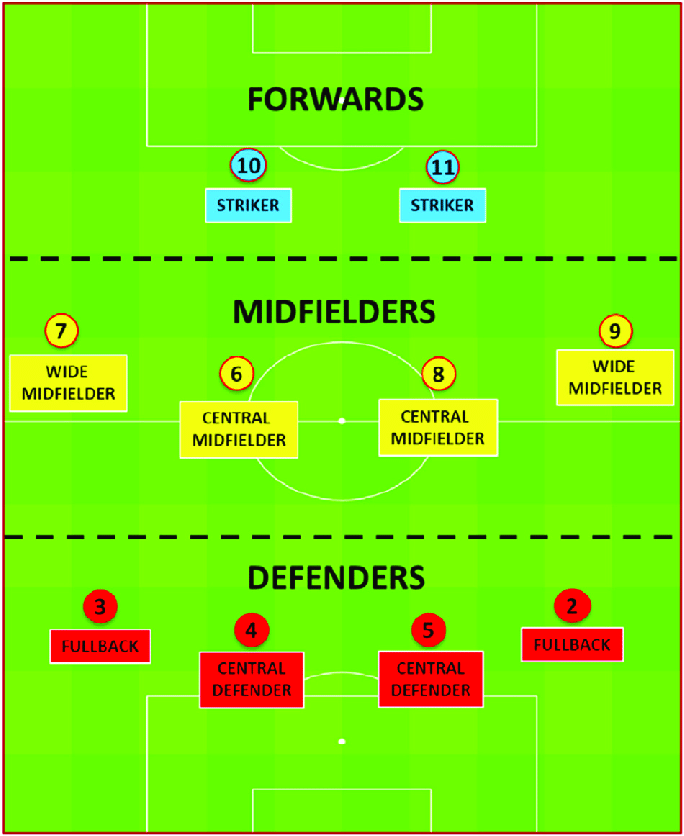

In [995]:
Image("images/player_layout.png")

The data contains 100+ columns, of which around 60 are important features to us. Most of the columns are player attributes which are rated from 1-99.
Info about each column can be found from Kaggle link above. 

In [12]:
fifa_data.head()

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,2023-09-22,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3


# Comments on Data Filtering 

1. Here, we make a decision to keep players from fifa 24 only. The data has info about players from last 4-5 different fifa versions, but that is not relevant to us. 

2. We limit players with overall rating > 70. This is a decision made by applying the domain knowledge. At first league level (the one I play) most players are 75-80+ rated, thus I have removed players below 70 to filter them out and keep our data relevant. 

**Note**: I also ran the entire notebook without putting the 70 rating filter, all the analysis runs in a very siilar way, dimension reduction and no. of clusters, the final output has more points and cluttered but with same pattern. You can comment the filtering line in next block and run the notebook if required. 

In [997]:
# Filter the data for fifa_version == 2024
fifa_24 = fifa_data[fifa_data['fifa_version'] == 24]

# I am only interested in players above 70 rating
fifa_24 = fifa_24[fifa_24['overall'] > 70]

fifa_24.describe().columns # numeric variables only

Index(['player_id', 'fifa_version', 'fifa_update', 'overall', 'potential',
       'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'club_team_id', 'league_id', 'league_level', 'club_jersey_number',
       'club_contract_valid_until_year', 'nationality_id', 'nation_team_id',
       'nation_jersey_number', 'weak_foot', 'skill_moves',
       'international_reputation', 'release_clause_eur', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_intercept

## Doing some basic Exploratory Data Analysis to understand the data and distribution

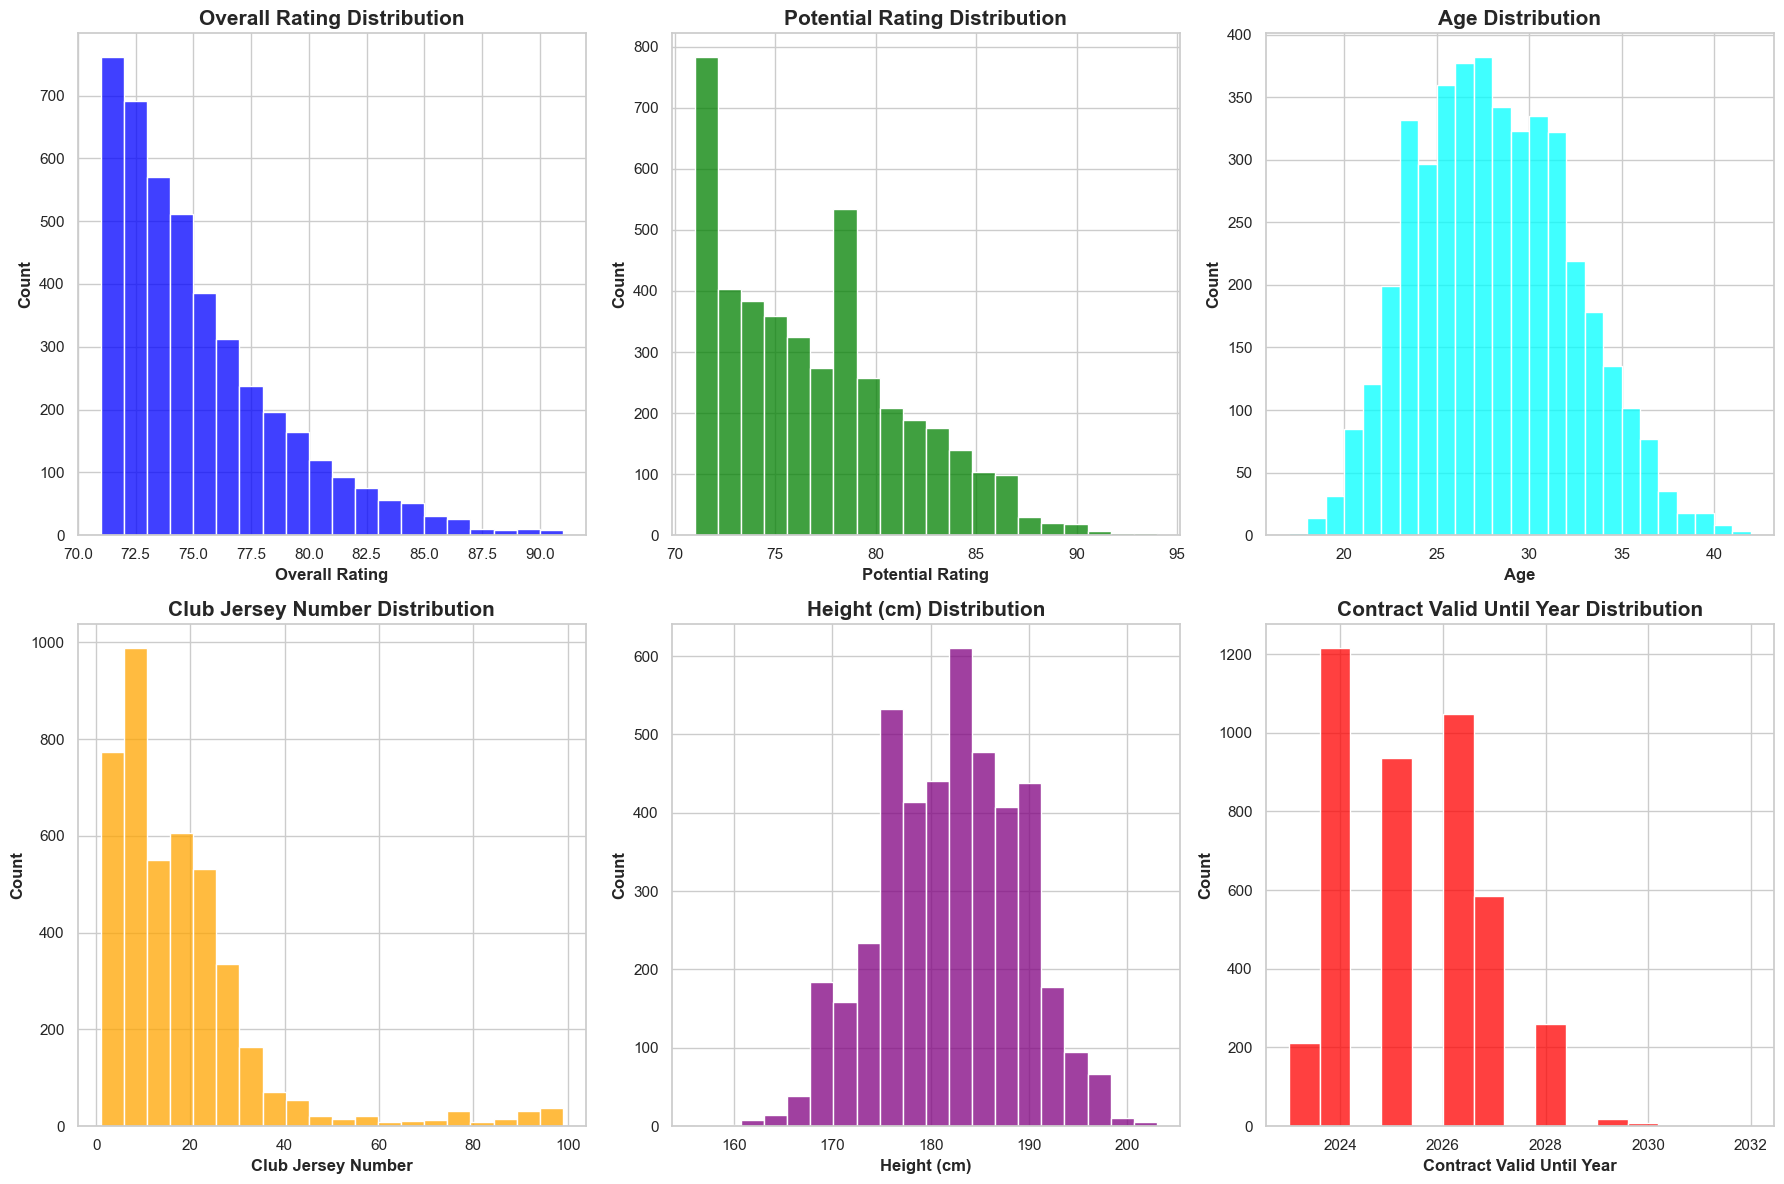

In [998]:

# Set a consistent style
sns.set_theme(style="whitegrid")

# Set the figure size
plt.figure(figsize=(18, 12))


plt.subplot(2, 3, 1)
sns.histplot(fifa_24['overall'], bins=20, kde=False, color="blue")
plt.xlabel('Overall Rating', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Overall Rating Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 2)
sns.histplot(fifa_24['potential'], bins=20, kde=False, color="green")
plt.xlabel('Potential Rating', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Potential Rating Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 3)
sns.histplot(fifa_24['age'], bins=25, kde=False, color="cyan")
plt.xlabel('Age', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Age Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 4)
sns.histplot(fifa_24['club_jersey_number'], bins=20, kde=False, color="orange")
plt.xlabel('Club Jersey Number', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Club Jersey Number Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 5)
sns.histplot(fifa_24['height_cm'], bins=20, kde=False, color="purple")
plt.xlabel('Height (cm)', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Height (cm) Distribution', fontsize=15, fontweight="bold")


plt.subplot(2, 3, 6)
sns.histplot(fifa_24['club_contract_valid_until_year'], bins=15, kde=False, color="red")
plt.xlabel('Contract Valid Until Year', fontsize=12, fontweight="bold")
plt.ylabel('Count', fontsize=12, fontweight="bold")
plt.title('Contract Valid Until Year Distribution', fontsize=15, fontweight="bold")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


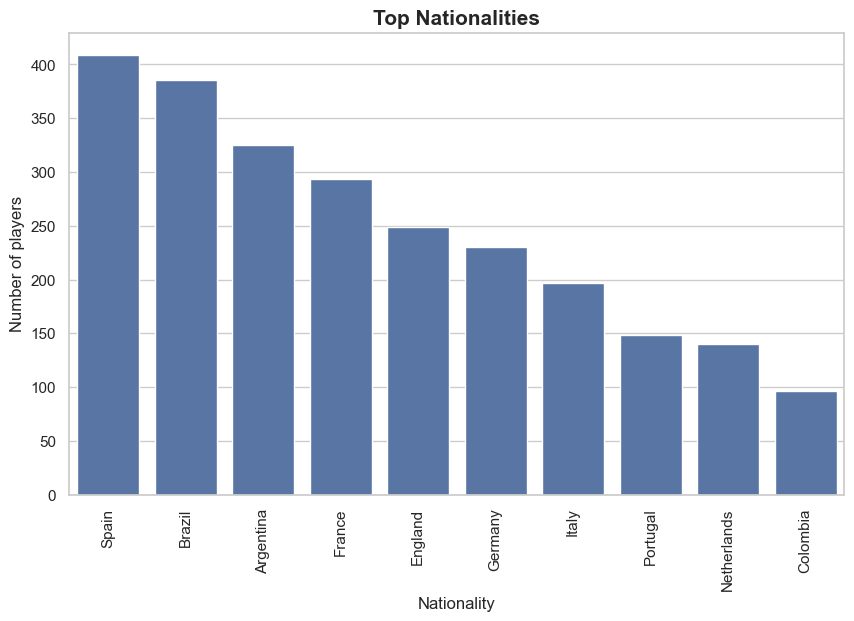

In [999]:
# barplot to understand the distribution of players country wise

top_nationalities=fifa_24.nationality_name.value_counts(ascending=False)[:10]

plt.figure(figsize=(10,6))
sns.barplot(top_nationalities)
plt.xlabel('Nationality')
plt.ylabel('Number of players')
plt.xticks(rotation=90)
plt.title('Top nationalities'.title(), fontsize=15, fontweight="bold");

### Updating dataset to keep only numerical cols for Dimension reduction and clustering.

In [1000]:
fifa_24 = fifa_24[['short_name', 'overall', 'potential',
       'value_eur', 'wage_eur', 'age', 'height_cm', 'weight_kg',
       'league_level', 'club_jersey_number',
       'club_contract_valid_until_year',
       'weak_foot', 'skill_moves',
       'international_reputation', 'release_clause_eur', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']]

### Identifying how many nulls we have in the dataset

In [1001]:
pd.set_option('display.max_rows', 500)
fifa_24.isnull().sum()

short_name                           0
overall                              0
potential                            0
value_eur                           38
wage_eur                            33
age                                  0
height_cm                            0
weight_kg                            0
league_level                        33
club_jersey_number                  33
club_contract_valid_until_year      33
weak_foot                            0
skill_moves                          0
international_reputation             0
release_clause_eur                 298
pace                               423
shooting                           423
passing                            423
dribbling                          423
defending                          423
physic                             423
attacking_crossing                   0
attacking_finishing                  0
attacking_heading_accuracy           0
attacking_short_passing              0
attacking_volleys        

# Comments on Data Cleaning

We can see above that we have some cols as nulls in the data
I looked through each column (eg. pace, dribbling, goalkeeping_speed, defending etc) - Some players have these metrics missing in the data/

Based on my data understanding putting in mean for missing values seems reasonable. We could potentially think of better ways to fill the data synthetically, but mean provides a good balance between speed of implementation and quality. (I tested by putting values synthetically, end result was similar)

In [1002]:
names = fifa_24.short_name.tolist() # saving names for later

fifa_24 = fifa_24.drop(['short_name'], axis = 1) # drop the short_name column 


In [1003]:
fifa_24 = fifa_24.fillna(fifa_24.mean())

## Scaling the data for PCA

In [1004]:
x = fifa_24.values # numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)
     

In [1005]:
# Calculate the Kaiser-Meyer-Olkin (KMO) measure for the dataset
kmo_all, kmo_model = calculate_kmo(x_scaled)

kmo_model


/usr/local/lib/python3.9/site-packages/factor_analyzer/utils.py:244: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



0.8889369731329977

### We can see the Kaiser-Meyer-Olkin (KMO) measure is almost 0.9, which is a strong indication for doing dimension reduction.

# Dimension Reduction

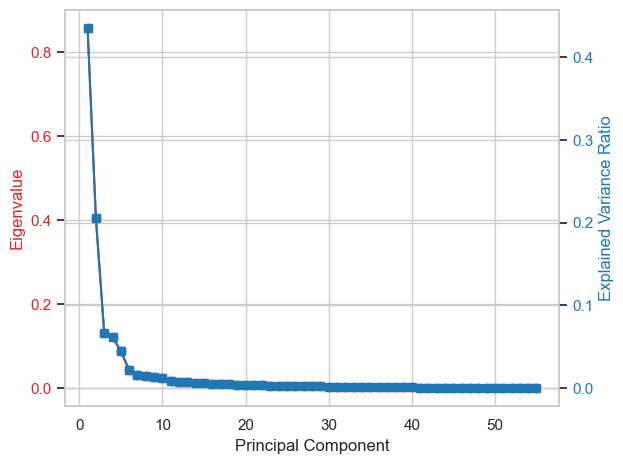

In [1006]:
pca_adjusted = PCA()
pca_adjusted.fit(x_scaled)

# Eigenvalues and Explained Variance Ratio
eigenvalues_adjusted = pca_adjusted.explained_variance_
explained_variance_ratio_adjusted = pca_adjusted.explained_variance_ratio_
cumulative_explained_variance_ratio_adjusted = np.cumsum(explained_variance_ratio_adjusted)

# Plotting the eigenvalues and explained variance ratio
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue', color=color)
ax1.plot(np.arange(1, len(eigenvalues_adjusted) + 1), eigenvalues_adjusted, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Explained Variance Ratio', color=color)
ax2.plot(np.arange(1, len(explained_variance_ratio_adjusted) + 1), explained_variance_ratio_adjusted, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

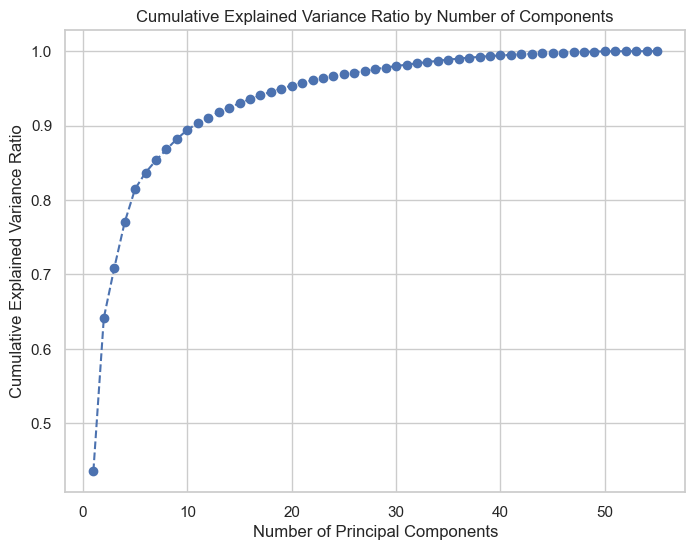

In [1007]:
# Plotting the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance_ratio_adjusted) + 1), cumulative_explained_variance_ratio_adjusted, 'o--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()

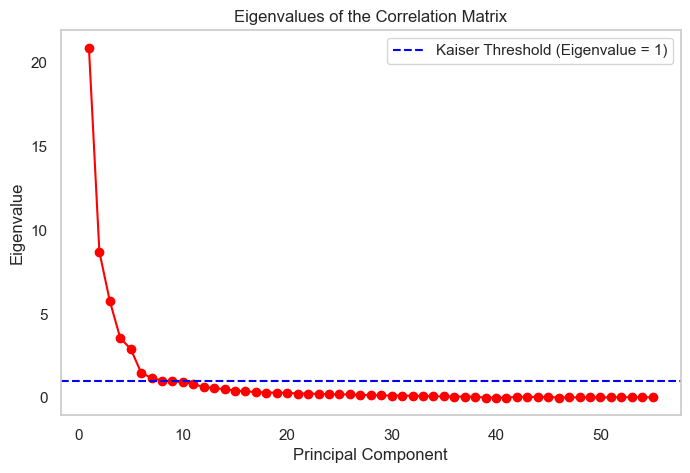

Number of components retained using the Kaiser Rule: 8


In [1008]:
# Compute the correlation matrix
correlation_matrix = np.corrcoef(x_scaled, rowvar=False)

# Compute eigenvalues of the correlation matrix
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)



plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', color='red')
plt.axhline(y=1, color='blue', linestyle='--', label='Kaiser Threshold (Eigenvalue = 1)')
plt.title('Eigenvalues of the Correlation Matrix')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid()
plt.show()

# Apply the Kaiser Stopping Rule (retain components with eigenvalue > 1)
kaiser_components = np.sum(eigenvalues > 1)
print(f"Number of components retained using the Kaiser Rule: {kaiser_components}")


In [1009]:
# Assuming you have already fit a PCA object called `pca_adjusted`
explained_variance_ratio = pca_adjusted.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Print the cumulative explained variance
for i, var in enumerate(cumulative_explained_variance, start=1):
    print(f"Principal Component {i}: {var:.4f}")

Principal Component 1: 0.4355
Principal Component 2: 0.6415
Principal Component 3: 0.7085
Principal Component 4: 0.7701
Principal Component 5: 0.8150
Principal Component 6: 0.8368
Principal Component 7: 0.8534
Principal Component 8: 0.8679
Principal Component 9: 0.8820
Principal Component 10: 0.8942
Principal Component 11: 0.9033
Principal Component 12: 0.9108
Principal Component 13: 0.9181
Principal Component 14: 0.9241
Principal Component 15: 0.9300
Principal Component 16: 0.9355
Principal Component 17: 0.9406
Principal Component 18: 0.9454
Principal Component 19: 0.9498
Principal Component 20: 0.9537
Principal Component 21: 0.9575
Principal Component 22: 0.9608
Principal Component 23: 0.9635
Principal Component 24: 0.9661
Principal Component 25: 0.9687
Principal Component 26: 0.9711
Principal Component 27: 0.9736
Principal Component 28: 0.9758
Principal Component 29: 0.9780
Principal Component 30: 0.9800
Principal Component 31: 0.9819
Principal Component 32: 0.9837
Principal Compone

# Comments on Dimension Reduction

While Kaiser Method suggest 8 PCA Components, based on my understanding of data and keeping in mind that we need to create clusters for this data. I will be using 2 & 3 PCAs, which still represent around 65% and 70% of data respectively. 

We had ~60 columns (or features) initially, reducing that to 2-3 while keeping around 70% explained variance is a good trade off. 


# 2D Clustering and Analysis

Let's start by using first 2 PCAs and builidng the clusters. We will use PCA1 and PCA2

In [1010]:
pca = PCA(n_components = 2)  #For Clustering
reduced = pd.DataFrame(pca.fit_transform(X_norm))
     

For a quick check, Running the Elbow method to identify number of clusters

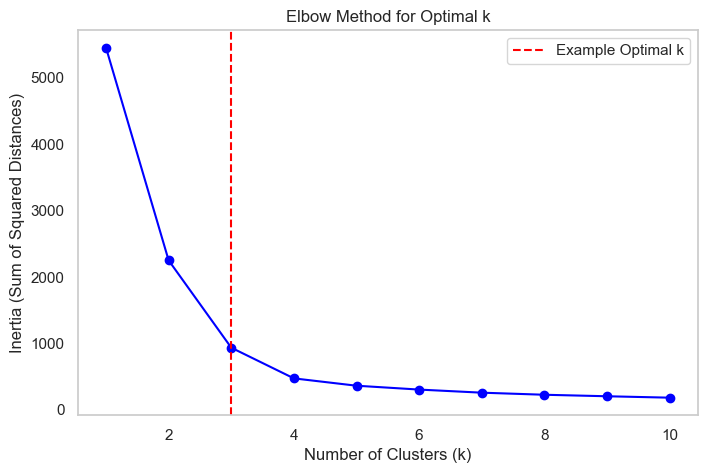

In [1011]:
# Calculate inertia for a range of cluster numbers
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.axvline(x=3, color='red', linestyle='--', label='Example Optimal k')
plt.legend()
plt.grid()
plt.show()


Validating the information by silhoutte method

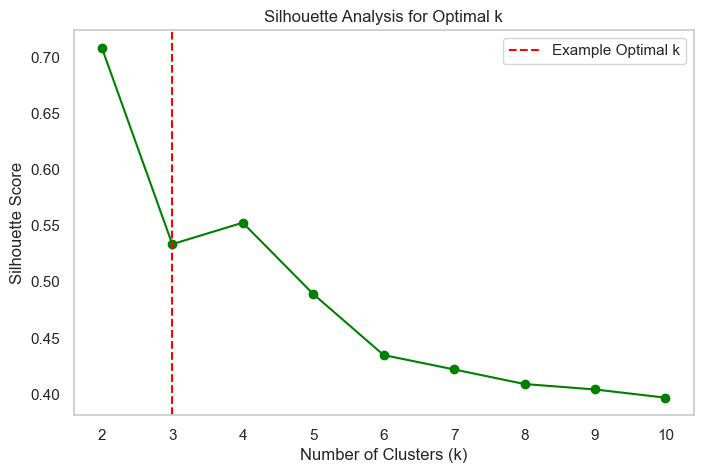

In [1012]:
silhouette_scores = []

# Compute silhouette scores for a range of cluster numbers
for k in range(2, 11):  # Silhouette cannot be computed for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced)
    score = silhouette_score(reduced, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, 'o-', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.axvline(x=3, color='red', linestyle='--', label='Example Optimal k')
plt.legend()
plt.grid()
plt.show()


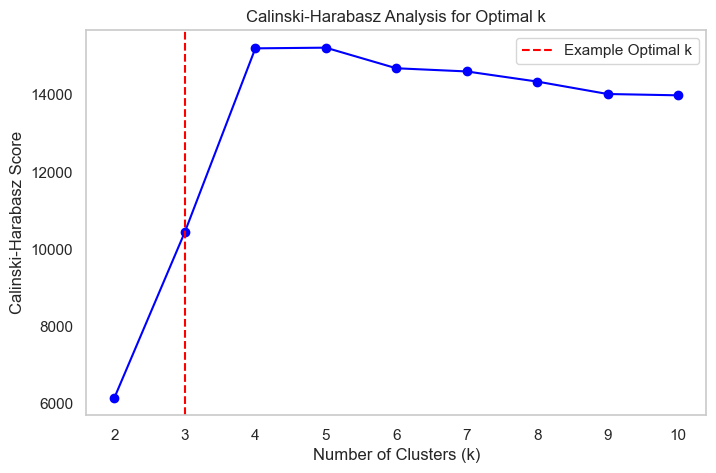

In [1013]:


calinski_scores = []

# Compute Calinski-Harabasz scores for a range of cluster numbers
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced)
    score = calinski_harabasz_score(reduced, labels)
    calinski_scores.append(score)

# Plot the Calinski-Harabasz scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), calinski_scores, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Analysis for Optimal k')
plt.axvline(x=3, color='red', linestyle='--', label='Example Optimal k')
plt.legend()
plt.grid()
plt.show()


# Comment on Number of CLusters

Based on Elbow method and Silhoutte and Calinski-Harabasz score analysis, 3 seems like the ideal number of clusters. We will start clustering based on that (based on my domain knowledge it should be 5 clsuters and I will explain later why)

In [1014]:
# specify the number of clusters
kmeans = KMeans(n_clusters=3)

# fit the input data
kmeans = kmeans.fit(reduced)

# get the cluster labels
labels = kmeans.predict(reduced)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()
     

In [1015]:
reduced['cluster'] = clusters
reduced['name'] = names
reduced.columns = ['PC1', 'PC2', 'cluster', 'name']
reduced.head(10)

,PC1,PC2,cluster,name
0,-1.269728,-1.174364,2,K. Mbappé
1,-0.895320,-0.673801,2,E. Haaland
2,-1.386461,-0.446947,2,K. De Bruyne
3,-1.167896,-1.356665,2,L. Messi
4,-1.049083,-0.981952,2,K. Benzema
5,-1.130042,-0.841114,2,R. Lewandowski
6,2.536565,-0.493748,1,T. Courtois
7,-1.101180,-0.640699,2,H. Kane
8,-1.008519,-1.321089,2,Vini Jr.
9,2.332738,-0.465320,1,Alisson


In [1016]:
# correlation_matrix = pd.DataFrame(x_scaled).corr()
# print(correlation_matrix)


### List of players to label. These are players from my team in career mode. They represent all positions. I have also added some extra players to make data more representative

### My goal is to identify where they fall and find similar players as replacement. 



In [1017]:

players_to_label = [
    "K. Mbappé", "L. Messi", "R. Lewandowski", "E. Haaland", "Cristiano Ronaldo",  # Attack
    "O. Watkins", "D. Ings", "P. Bamford" , # Attack
    "K. De Bruyne", "P. Pogba", "L. Modrić", "F. De Jong", "T. Kroos", # Mid
    "P. Zieliński", "J. McGinn", "L. Bailey", "I. Gündoğan", "R. Højbjerg", # Mid
    "V. van Dijk", "J. Tomkins", "J. Stones", "K. Koulibaly", "J. Laporte", # Defenders
    "C. Coady", "J. Moreno", "O. Skipp", "J. Koundé", "F. Mendy", # Full Backs
    "W. Szczęsny", "R. Patricio", "D. Raya", "M. Ginter" #Goal Keepers
]

In [1018]:


# Function to create cluster outlines using Convex Hull
def add_cluster_outlines(fig, data, cluster_col, x_col, y_col, color_scale):
    unique_clusters = data[cluster_col].unique()
    for cluster in unique_clusters:
        cluster_points = data[data[cluster_col] == cluster][[x_col, y_col]].values
        if len(cluster_points) > 2:  
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            # Add cluster outline as a filled scatter plot
            fig.add_trace(
                go.Scatter(
                    x=hull_points[:, 0],
                    y=hull_points[:, 1],
                    mode='lines',
                    fill='toself',
                    line=dict(color=color_scale[cluster % len(color_scale)], width=2),
                    opacity=0.2,
                    name=f"Cluster {cluster} Outline",
                    showlegend=False,
                )
            )

reduced['cluster'] = reduced['cluster'].astype('category')
reduced['cluster'] = reduced['cluster'].cat.rename_categories({i: i+1 for i in range(len(reduced['cluster'].cat.categories))})

color_scale = px.colors.qualitative.Set1  

# Create scatter plot for all points (dots)
fig = px.scatter(
    reduced,
    x="PC1",
    y="PC2",
    color="cluster",  # Now treated as categorical
    color_discrete_sequence=color_scale,  
    opacity=0.6,
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
    category_orders={"cluster": sorted(reduced['cluster'].unique())},  
)

# Add cluster outlines
add_cluster_outlines(fig, reduced, "cluster", "PC1", "PC2", color_scale)

# Update layout for better appearance
fig.update_layout(
    title="2 Dimension Cluster Plot",
    title_font=dict(size=20, family="Arial Black"),
    xaxis=dict(title="PC 1", titlefont=dict(size=16), showgrid=False),
    yaxis=dict(title="PC 2", titlefont=dict(size=16), showgrid=False),
    template="plotly_white",
    legend=dict(
        title="Clusters",
        font=dict(size=12),
        orientation="v", 
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,  
        bordercolor="Black",
        borderwidth=1,
        bgcolor="white",
    ),
    width=1000,
    height=700,
)

# Show plot
fig.show()


## In the above figure we can see 3 different clusters, which seem to be well strcutured, with minimal overlap. To understand the clusters let's plot player names into it 

In [1019]:
# Create the scatter plot 
fig = px.scatter(
    reduced,
    x="PC1",
    y="PC2",
    color="cluster",  
    color_discrete_sequence=px.colors.qualitative.Set1, 
    opacity=0.6,
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
    category_orders={"cluster": sorted(reduced['cluster'].unique())},
)


add_cluster_outlines(fig, reduced, "cluster", "PC1", "PC2", px.colors.qualitative.Set1)


highlighted_players = reduced[reduced['name'].isin(players_to_label)]
for _, row in highlighted_players.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row['PC1']],
            y=[row['PC2']],
            mode='markers',
            marker=dict(size=8, color='red', symbol='circle', line=dict(width=1, color='black')),
            name=None,  # Remove player from legend
            showlegend=False,
        )
    )


for _, row in highlighted_players.iterrows():
    fig.add_annotation(
        x=row['PC1'],
        y=row['PC2'] - 0.1,  
        text=row['name'] + (" 🐐" if row['name'] == "L. Messi" else ""),
        showarrow=False,  
        font=dict(size=12, color='black', family="Arial Black"),
        align="left",
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="white",
        opacity=0.8
    )

# Update layout for better appearance (no changes made)
fig.update_layout(
    title="3 Cluster scatter plot with marked Specific Players",
    title_font=dict(size=20, family="Arial Black"),
    xaxis=dict(title="PC 1", titlefont=dict(size=16), showgrid=False),
    yaxis=dict(title="PC 2", titlefont=dict(size=16), showgrid=False),
    template="plotly_white",
    legend=dict(
        title="Clusters",
        font=dict(size=12),
        orientation="v",  
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,  
        bordercolor="Black",
        borderwidth=1,
        bgcolor="white",
    ),
    width=1000,
    height=700,
)

# Show plot
fig.show()


# Comment on Clustering Outcome
The 3 clusters, while well structured, seem to put strikers (Lewandowski, Mbappe etc) in same group as mid fielders (Toni Kroos, De bruyne etc). Similarly, full backs (Left and right defensive players) are falling somewhere between 1st and 3rd Cluster.

Now based on my knowledge, I expect 5 clusters at a high level - Goalkeepers, Centre Backs, Full Backs, Midfielders and attackers. So let's try same steps but with 5 Clusters

In [1020]:

reduced = reduced.drop(["name", "cluster"], axis=1)

# specify the number of clusters
kmeans = KMeans(n_clusters=5)

# fit the input data
kmeans = kmeans.fit(reduced)

# get the cluster labels
labels = kmeans.predict(reduced)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()
     

In [1021]:
reduced['cluster'] = clusters
reduced['name'] = names
reduced.columns = ['PC1', 'PC2', 'cluster', 'name']
reduced.head(10)

,PC1,PC2,cluster,name
0,-1.269728,-1.174364,0,K. Mbappé
1,-0.895320,-0.673801,0,E. Haaland
2,-1.386461,-0.446947,3,K. De Bruyne
3,-1.167896,-1.356665,0,L. Messi
4,-1.049083,-0.981952,0,K. Benzema
5,-1.130042,-0.841114,0,R. Lewandowski
6,2.536565,-0.493748,2,T. Courtois
7,-1.101180,-0.640699,3,H. Kane
8,-1.008519,-1.321089,0,Vini Jr.
9,2.332738,-0.465320,2,Alisson


## I will adding label positions myslef to make the clusters more understandable, they are not coming from actual data.

In [1022]:
# Predefined label positions
label_positions = {
    'Goalkeeper': {'PC1': 2.5, 'PC2': -0.5},
    'Striker': {'PC1': 0, 'PC2': -1},
    'Midfield': {'PC1': -0.5, 'PC2': 0},
    'Full Back': {'PC1': -0.3, 'PC2': 0.5},
    'Defender': {'PC1': 0.2, 'PC2': 1},
}


reduced['cluster'] = reduced['cluster'].astype('category')
reduced['cluster'] = reduced['cluster'].cat.rename_categories({i: i+1 for i in range(len(reduced['cluster'].cat.categories))})

color_scale = px.colors.qualitative.Set1  # Use a distinct color palette for clusters

# Create scatter plot for all points (dots) with discrete legend
fig = px.scatter(
    reduced,
    x="PC1",
    y="PC2",
    color="cluster",  
    color_discrete_sequence=color_scale,  
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
    category_orders={"cluster": sorted(reduced['cluster'].unique())},  
)

# Add cluster outlines
add_cluster_outlines(fig, reduced, "cluster", "PC1", "PC2", color_scale)

# Add highlighted players with red markers
highlighted_players = reduced[reduced['name'].isin(players_to_label)]
for _, row in highlighted_players.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row['PC1']],
            y=[row['PC2']],
            mode='markers',
            marker=dict(size=8, color='red', symbol='circle', line=dict(width=1, color='black')),
            name=None,  
            showlegend=False,
        )
    )

# Add labels for specific player annotations
for _, row in highlighted_players.iterrows():
    fig.add_annotation(
        x=row['PC1'],
        y=row['PC2'] - 0.1,  
        text=row['name'] + (" 🐐" if row['name'] == "L. Messi" else ""),
        showarrow=False,  
        font=dict(size=12, color='black', family="Arial Black"),
        align="left",
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="white",
        opacity=0.8
    )

# Add predefined labels with an arrow pointing to the original coordinates
for label, position in label_positions.items():
    fig.add_annotation(
        x=position['PC1'],  
        y=position['PC2'], 
        text=label,
        showarrow=True,  
        arrowhead=3,
        arrowsize=2,
        ax=150,  
        ay=-20, 
        font=dict(size=14, color='black'), 
        align="center", 
        bgcolor="white",
        opacity=0.8
    )

# Update layout for better appearance
fig.update_layout(
    title="5 Cluster scatter plot with marked Specific Players",
    title_font=dict(size=20, family="Arial Black"),
    xaxis=dict(title="PC 1", titlefont=dict(size=16), showgrid=False),
    yaxis=dict(title="PC 2", titlefont=dict(size=16), showgrid=False),
    template="plotly_white",
    showlegend=True,  
    legend=dict(
        title="Clusters",
        font=dict(size=12),
        orientation="v",  
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,  
        bordercolor="Black",
        borderwidth=1,
        bgcolor="white",
    ),
    width=1000,
    height=700,
)

# Show plot
fig.show()


# Comment on 5 cluster approach and my analysis

In the above plot 5 clear cluster can be clearly visualised. We can see most of the players fall in the cluster we expect them to based on their position. (we did not have this info in data when clustering)

We also notice some interesting occurences, such as Ferlan Mendy. He is placed in the cluster of midfielders (but very close to full backs) This related to the way he plays actually, as he often plays left mid or even if he is playing at full back, he is moving a lot and has a mid field type game style. 

And we can see L. Messi clearly being almost at an extreme edge of the striker cluster, which should not need any additional explanation 🐐

# 3 PCA approach (70% variance explained)

While 2 PCA was enougha (covering 65% sum of explained variance), demonstarting the PC3 approach also (3D clustering)

In [1023]:
pca = PCA(n_components = 3)  #For Clustering
reduced = pd.DataFrame(pca.fit_transform(X_norm))
     

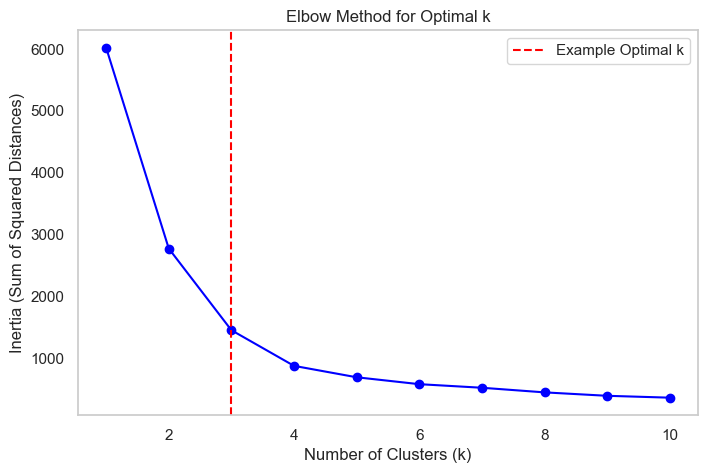

In [1024]:
# Calculate inertia for a range of cluster numbers
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.axvline(x=3, color='red', linestyle='--', label='Example Optimal k')
plt.legend()
plt.grid()
plt.show()


In [1025]:

# specify the number of clusters
kmeans = KMeans(n_clusters=3)

# fit the input data
kmeans = kmeans.fit(reduced)

# get the cluster labels
labels = kmeans.predict(reduced)

# centroid values
centroid = kmeans.cluster_centers_

# cluster values
clusters = kmeans.labels_.tolist()
     

In [1026]:
reduced['cluster'] = clusters
reduced['name'] = names
reduced.columns = ['PC1', 'PC2', 'PC3', 'cluster', 'name']
reduced.head(10)

,PC1,PC2,PC3,cluster,name
0,-1.269728,-1.174364,1.107981,0,K. Mbappé
1,-0.895320,-0.673801,0.900312,0,E. Haaland
2,-1.386461,-0.446947,1.478575,0,K. De Bruyne
3,-1.167896,-1.356665,0.985785,0,L. Messi
4,-1.049083,-0.981952,0.690314,0,K. Benzema
5,-1.130042,-0.841114,0.804811,0,R. Lewandowski
6,2.536565,-0.493748,1.385038,2,T. Courtois
7,-1.101180,-0.640699,0.910221,0,H. Kane
8,-1.008519,-1.321089,1.107061,0,Vini Jr.
9,2.332738,-0.465320,1.340172,2,Alisson


In [1027]:
import plotly.express as px
import plotly.graph_objects as go

# Start cluster count from 1 (assuming reduced['cluster'] starts from 0)
reduced['cluster'] = reduced['cluster'] + 1

# Create the 3D scatter plot

color_scale = px.colors.qualitative.Set1  # Use a distinct color palette for clusters

fig = px.scatter_3d(
    reduced,
    x="PC1",
    y="PC2",
    z="PC3",
    color="cluster",
    color_discrete_sequence=color_scale,
    opacity=0.6,
    hover_name="name",  # Add player names as hover text
    labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2", "PC3": "Principal Component 3"},
    category_orders={"cluster": sorted(reduced['cluster'].unique())},
)

# Highlight specified players in red
highlighted_players = reduced[reduced['name'].isin(players_to_label)]
for _, row in highlighted_players.iterrows():
    fig.add_trace(
        go.Scatter3d(
            x=[row['PC1']],
            y=[row['PC2']],
            z=[row['PC3']],
            mode='markers+text',
            text=[row['name']],
            textposition="top center",
            textfont=dict(size=10, color='black'),
            marker=dict(size=8, color='red', symbol='circle', line=dict(width=1, color='black')),
            name=None,  # Exclude from legend
            showlegend=False,
        )
    )


# Update layout for better appearance
fig.update_layout(
    title="3D Scatter Plot Highlighting Specific Players",
    title_font=dict(size=20, family="Arial Black"),
    scene=dict(
        xaxis=dict(title="PC 1", titlefont=dict(size=16), showgrid=False),
        yaxis=dict(title="PC 2", titlefont=dict(size=16), showgrid=False),
        zaxis=dict(title="PC 3", titlefont=dict(size=16), showgrid=False),
    ),
    template="plotly_white",
    legend=dict(
        title="Clusters",
        font=dict(size=12),
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.05,
        bordercolor="Black",
        borderwidth=1,
        bgcolor="white",
    ),
    width=1000,
    height=800,
)

# Show plot
fig.show()


# Comment on 3D clustering 

The 3D clusters can be interpreted similarly to 2D. However I believe 2D plots are much better as they are much easier to understand. 